# Assignment 2: CRF sequence tagging for Move Queries

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [6]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

# 1. Split the training data into 80% training, 20% development set (5 marks)

In [10]:
# Splitting the data into training and development sets with no shuffling.
td_length = len(training_data)
split_length = int(td_length * 0.8)
train_set = training_data[:split_length]
dev_set = training_data[split_length:]

print(f'Initial training data length: {len(training_data)}')
print(f'Split training data length: {len(train_set)}')
print(f'Test data length: {len(dev_set)}')


Initial training data length: 9775
Split training data length: 7820
Test data length: 1955


In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_set, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# # prepare the test data:
# raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
# test_data = [preProcess(example) for example in raw_test_data]
print(len(dev_set), "instances")
print(sum([len(sent) for sent in dev_set]), "words")

1955 instances
20225 words


In [13]:
print("testing tagger...")
preds = []
y_test = []
for sent in dev_set:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.68       410
          I-GENRE       0.90      1.00      0.95       

/Users/Mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

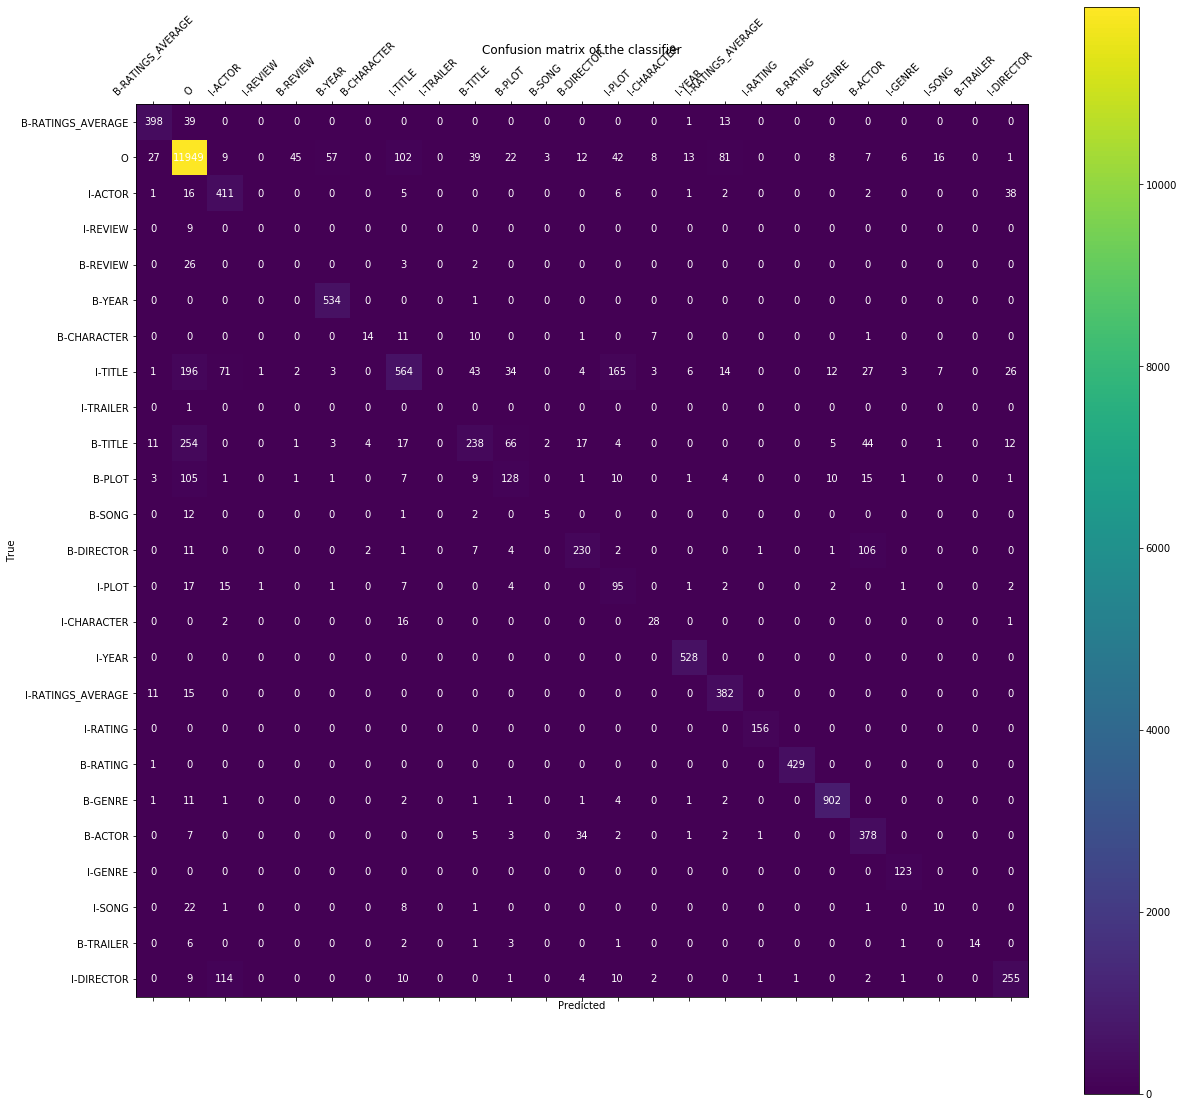

In [16]:
confusion_matrix_heatmap(y_test, preds)

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


In [17]:
# This was done earlier in the notebook

# 2. Error analysis 1: False positives (10 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (10 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 4. Using POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [18]:
# # a postagger for use in exercises
# posttagger = CRFTagger()
# posttagger.set_model_file("crf_pos.tagger")
# # example use:
# words = ["john", "likes", "mary", "and", "bill"]
# print(posttagger.tag(words))

# 5. Feature experimentation for optimal macro average (20 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format. You could try more suffixes/prefixes of the curret word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes. Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `engtest.bio.txt`) as your final piece of code.

# Question 2 & 3: False positives and false negatives

In [19]:
# Output of the classification report as a dictionary
report = classification_report(y_test, preds, output_dict=True)

# Classification report as a dataframe
df_report = pd.DataFrame(report).transpose()

# Sorted dataframe by precision
sorted_prec_df = df_report.sort_values(by='precision')
display(sorted_prec_df.head())

# Classes with lowest precison (false positives)
fpos = sorted_prec_df.index[:5].to_list()

# Sorted dataframe by recall
sorted_recall_df = df_report.sort_values(by='recall')
display(sorted_recall_df.head())

# Classes with lowest recall (false negatives)
fneg = sorted_recall_df.index[:5].to_list()

,precision,recall,f1-score,support
I-TRAILER,0.000000,0.000000,0.000000,1.0
I-REVIEW,0.000000,0.000000,0.000000,9.0
B-REVIEW,0.000000,0.000000,0.000000,31.0
I-PLOT,0.278592,0.641892,0.388548,148.0
I-SONG,0.294118,0.232558,0.259740,43.0


,precision,recall,f1-score,support
I-TRAILER,0.000000,0.000000,0.000000,1.0
B-REVIEW,0.000000,0.000000,0.000000,31.0
I-REVIEW,0.000000,0.000000,0.000000,9.0
I-SONG,0.294118,0.232558,0.259740,43.0
B-SONG,0.500000,0.250000,0.333333,20.0


In [20]:
print(f'List of classes with lowest precision: {fpos}')
print(f'List of classes with lowest recall: {fneg}\n')

print('The classes with the lowest precision will be used to find the false postives (FP).')
print('The classes with the lowest recall will be used to find the false negatives (FN).')

List of classes with lowest precision: ['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'I-PLOT', 'I-SONG']
List of classes with lowest recall: ['I-TRAILER', 'B-REVIEW', 'I-REVIEW', 'I-SONG', 'B-SONG']

The classes with the lowest precision will be used to find the false postives (FP).
The classes with the lowest recall will be used to find the false negatives (FN).


In [21]:
# list of FP or FN words
f_pos_words = []
f_neg_words = []

# List of FP or FN sentences
fpos_error_sentences = []
fneg_error_sentences = []

# Details of FP and FN occurences 
fp_details = []
fn_details = []

print("testing tagger...")
preds = []
y_test = []
for sent in dev_set:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    word = [x[0] for x in sent]

    # FALSE POSITIVE LOOP
    
    # check if predicted label is in FP list of labels
    for pred_label in sent_preds:
        if pred_label in fpos: 
            
            # get the index of the predicted label in the sentence
            ind = sent_preds.index(pred_label)
            # get true label
            true_label = sent_true[ind]
            
            # labels that don't match are false positives
            if pred_label != true_label:
                
                # get the false positive words
                false_pos_word = sent[ind][0]
                f_pos_words.append(false_pos_word)
                
                # get the sentence containing the false positive error
                fp_error_sent = ' '.join(word)
                fpos_error_sentences.append(fp_error_sent)
                
                # additional info about the false positive
                word_sent_predlabel_truelabel = [false_pos_word, fp_error_sent, pred_label, true_label]
                fp_details.append(word_sent_predlabel_truelabel)
                break

                
    # FALSE NEGATIVE LOOP
    
    # check if true label is in FN list of labels
    for true_label in sent_true:
        if true_label in fneg:
            
            # get the index of the true label in the sentence
            ind = sent_true.index(true_label)
            # get predicted label
            pred_label = sent_preds[ind]
            
            # labels that don't match are false negatives
            if true_label != pred_label:
                
                # get the false negative words
                false_neg_word = sent[ind][0]
                f_neg_words.append(false_neg_word)
                
                # get the sentence containing the false negative error
                fn_error_sent = ' '.join(word)
                fneg_error_sentences.append(fn_error_sent) 
                
                # additional info about the false negative
                word_sent_pred_true = [false_neg_word, fn_error_sent, pred_label, true_label]
                fn_details.append(word_sent_pred_true)
                break
    
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")


testing tagger...
done


## Sentences with a false positive
All sentences in the development set that contained a false positive class from the list of lowest precision classes are printed below.

Some sentences contained more than one false positive occurence, but only the unique sentences were printed for clarity. A sample of further analysis of the false positives is then given.

In [22]:
for sentence in set(fpos_error_sentences):
    print(sentence)

whats the best family movie of the past decade thats is rated at least a four
who directed fear of a black hat
what is the best romantic comedy that came out in 2011
what movie studio produced digital monster x evolution
what was the best horror movie last year
when is so proudly we hail released
what is a movie about a party whose ratings averaged about a nine
who directed the sweetest thing
what was the last science fiction movie that won an oscar
please give me a glimpse of that movie kiss me kate
what is the best drama ever directed by ingmar bergman
what is the best fantasy movie of all time
who starred in all my friends are funeral singers
kiss me deadly
who directed lornas silence
who directed lets fish
my darling clementine
what is the movie gekijouban fate stay night unlimited blade works about
what is the best psychological drama that was made in the 1950 s
where can i find the movie dumping lisa
what is a nine star rated movie that is rated nc 17 and involves drugs
what is t

### Analysis of false positives

In [23]:
fp_samples = fp_details[:5]
for fp in fp_samples:
    print(f'False positive word: "{fp[0]}"')
    print(f'Sentence with false positive: "{fp[1]}"')
    print(f'predicted label: {fp[2]}, true label: {fp[3]}\n')


False positive word: "daughter"
Sentence with false positive: "what genre is the movie my date with the presidents daughter"
predicted label: I-PLOT, true label: I-TITLE

False positive word: "jesse"
Sentence with false positive: "what is becoming jesse tate"
predicted label: I-PLOT, true label: I-TITLE

False positive word: "affairs"
Sentence with false positive: "what is internal affairs"
predicted label: I-PLOT, true label: I-TITLE

False positive word: "hawks"
Sentence with false positive: "what is such hawks such hounds about"
predicted label: I-PLOT, true label: I-TITLE

False positive word: "places"
Sentence with false positive: "what is trading places"
predicted label: I-PLOT, true label: I-TITLE



In [24]:
# 10 most common false positive words and respective counts
fp_word_count = Counter(f_pos_words)
fp_10 = fp_word_count.most_common(10)
fp_10

[('best', 42),
 ('of', 9),
 ('me', 6),
 ('oscar', 3),
 ('life', 3),
 ('a', 3),
 ('world', 2),
 ('lisa', 2),
 ('in', 2),
 ('fish', 2)]

In [25]:
# A selection of the most misclassified false negatives from the classes with the worst precision
c_fp6 = fp_10[:6]
fp6 = [x[0] for x in c_fp6]
fp6

['best', 'of', 'me', 'oscar', 'life', 'a']

## Sentences with a false negative
All sentences in the development set that contained a false negative class from the list of lowest precision classes are printed below.

Some sentences contained more than one false negative occurence, but only the unique sentences were printed for clarity. A sample of further analysis of the false negatives is then given.

In [26]:
for sentence in set(fneg_error_sentences):
    print(sentence)

could you show me a website with detailed reviews of purple rain
can you let me know what reviews people of my age group gave for purple rain
i am interested in the movie evita but i want to see what people thought of the movie first
which movie with judy garland is over the rainbow from
can you show me some reviews for purple rain
where can i find good reviews about the movie purple rain
find me the movie with the song over the rainbow
search for soundtracks of movies having come what may in them
please show me the comments viewers had and whether they found it lovely or boring
do you know whether a hard day s night is any good
what were the reviews like for purple rain
could you show me some part of the new indiana jones movie
show me the movie with singin in the rain
what do you think of the movie a hard day s night
please show me a website with reviews of a hard day s night
show me if any movie has the song come what may in it
what was the movie that featured that song over the rai

### Analysis of false negatives

In [27]:
fn_samples = fn_details[:5]
for fn in fn_samples:
    print(f'False negatives word: "{fn[0]}"')
    print(f'Sentence with false negative: "{fn[1]}"')
    print(f'predicted label: {fn[2]}, true label: {fn[3]}\n')

False negatives word: "reviews"
Sentence with false negative: "can you show me some reviews for purple rain"
predicted label: O, true label: B-REVIEW

False negatives word: "reviews"
Sentence with false negative: "where can i find good reviews about the movie purple rain"
predicted label: O, true label: B-REVIEW

False negatives word: "people"
Sentence with false negative: "what are people saying about purple rain"
predicted label: O, true label: B-REVIEW

False negatives word: "reviews"
Sentence with false negative: "could you show me a website with detailed reviews of purple rain"
predicted label: O, true label: B-REVIEW

False negatives word: "reviews"
Sentence with false negative: "can you let me know what reviews people of my age group gave for purple rain"
predicted label: O, true label: B-REVIEW



In [28]:
# 10 most common false negative words and respective counts
fn_word_count = Counter(f_neg_words)
fn_10 = fn_word_count.most_common(10)
fn_10

[('reviews', 12),
 ('think', 6),
 ('come', 6),
 ('people', 5),
 ('over', 5),
 ('opinions', 1),
 ('review', 1),
 ('comments', 1),
 ('rate', 1),
 ('sentiment', 1)]

In [29]:
# 5 most common false negatives from the worst recall classes
c_fn5 = fn_10[:5]
fn5 = [x[0] for x in c_fn5]
fn5

['reviews', 'think', 'come', 'people', 'over']

## Question 4: Part-Of-Speech tagging

The CRF tagger is is used to add part-of-speech (POS) tags to the words in each sentence in the preProcess fucntion. The word and POS tag are then concatenated together and returned as well as the class.

In [30]:
# CRF tagger
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    # The POS tag of each word in the sentence is found
    words = [x[0] for x in example]
    tagged_words = posttagger.tag(words)
    
    # The word and POS tag are concatenated together
    w_and_tags = [x[0] +'@'+ x[1] for x in tagged_words]
    
    # The concatenated word and POS tags and BIO labels are put into a tuple.
    w_label = [x[1] for x in example]
    preprocessed_example = [(x,y) for x,y in zip(w_and_tags, w_label)]
    
    return preprocessed_example


The raw training data was then preprocessed again to include the POS tags. Following the preprocessing, the training data was split into a training set and a development set. The prepr

In [31]:
# Preprocessing the raw data to include the POS tags
training_data = [preProcess(example) for example in raw_training_data]

# Splitting the data into a training set and a development set
td_length = len(training_data)
split_length = int(td_length * 0.8)
train_set = training_data[:split_length]
dev_set = training_data[split_length:]

print(f'Initial training data length: {len(training_data)}')
print(f'Split training data length: {len(train_set)}')
print(f'Test data length: {len(dev_set)}\n')

# check the effect of pre-processing
print(f"A sample of the modified preprocessing:\n {train_set[0]}")

Initial training data length: 9775
Split training data length: 7820
Test data length: 1955

A sample of the modified preprocessing:
 [('what@WP', 'O'), ('movies@VBZ', 'O'), ('star@NNP', 'O'), ('bruce@NNP', 'B-ACTOR'), ('willis@NNP', 'I-ACTOR')]


### Modification of the get_features function

With the POS tags concatenated with the words, the get_features function is modified to split the the words on the symbol "@". The POS tags are then used as features.



In [32]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    # The words and POS tokens are split
    token_and_POS = tokens[idx]
    split_token = token_and_POS.split("@")
    token = split_token[0]
    
    POS_token = split_token[1]
    
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    # The word and POS added as features
    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+POS_token)


#     print(feature_list)
    return feature_list


The CRF tagger is initialised and trained on the train_set. The test data is prepared and the tagger is then tested.

In [33]:

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_set, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
print(len(dev_set), "instances")
print(sum([len(sent) for sent in dev_set]), "words")

training tagger...
done
1955 instances
20225 words


In [34]:
print("testing tagger...")
preds = []
y_test = []
for sent in dev_set:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [35]:
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.64      0.85      0.73       433
      B-CHARACTER       0.68      0.34      0.45        44
       B-DIRECTOR       0.75      0.64      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.46      0.47      0.47       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.54      0.35      0.42        20
          B-TITLE       0.68      0.34      0.45       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.65      0.83      0.73       482
      I-CHARACTER       0.55      0.60      0.57        47
       I-DIRECTOR       0.75      0.64      0.69       410
          I-GENRE       0.90      1.00      0.95       

/Users/Mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Effect of the POS tags on the accuracy
The initial macro f1-score from the first classification report was 0.62. With the addition of the POS tags as features, the macro f1-score on the same test data improved to 0.63.

The two classificaiton reports were put into pandas dataframes to inspect the effects of the addition of POS tags on the classes. The difference between the two classification reports was examined and sorted by the classes with the largest improvement in the f1-score.

In [36]:
# dataframe of the POS classifcation report 
pos_report = classification_report(y_test, preds, output_dict=True)
df_pos = pd.DataFrame(pos_report).transpose()

# POS report subtracted from inital report
diff_df = df_pos - df_report

# Dataframe comparing the accuracy metrics
metrics_df = diff_df.loc[['accuracy', 'macro avg', 'weighted avg']]
metrics_df = metrics_df.drop('support', axis=1)
metrics_df.iloc[0,:2] = np.nan

# Dataframe of the difference between the classifcations reports
diff_df['support'] = df_report['support']
diff_df = diff_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Classification was then sorted by the f1-score difference
diff_df = diff_df.sort_values(by='f1-score', ascending=False)
diff_df

,precision,recall,f1-score,support
B-SONG,0.038462,0.100000,0.090909,20.0
I-SONG,0.018382,0.116279,0.069930,43.0
B-TRAILER,0.000000,0.035714,0.031008,28.0
B-CHARACTER,-0.018182,0.022727,0.017045,44.0
I-TITLE,0.070684,-0.005922,0.015596,1182.0
B-PLOT,-0.020419,0.043624,0.012987,298.0
I-RATINGS_AVERAGE,0.016595,-0.002451,0.008992,408.0
B-RATINGS_AVERAGE,0.004927,0.008869,0.006881,451.0
I-DIRECTOR,-0.006767,0.014634,0.005918,410.0
I-YEAR,0.006957,0.000000,0.003628,528.0


Two of the worst performing classes that were in the 5 lowest performing recall classes underwent significant improvements with the addition of POS tags as features. The f1-score of classes "B-SONG" and "I-SONG" improved by 9.1% and 7% respectively.

The metrics dataframe of the difference between the two classification reports shows an improvement in the precision, recall and f1-score in all averaged metrics (accuracy, macro avg and weighted avg).

In [37]:
metrics_df

,precision,recall,f1-score
accuracy,NaN,NaN,0.001681
macro avg,0.002261,0.011589,0.007901
weighted avg,0.005098,0.001681,0.002298


## Question 5: Feature experimentation for optimal macro average

A number of different features were used in to explore the optimum macro f1-score. The features that were experimented included:
 - Prefixes and suffixes: The initial get_features function used only 3 suffixes. This was expanded to try up to 6 prefixes and suffixes.
 - Previous/next words and tokens: The previous and next two words and POS tokens were used as features, and various combinations of the words and tokens were trialled
 - Frequently misclassified words: The words that led to low scores in poor performing precision and recall classes were located and attempts to rectify this were made


In [67]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    token_and_POS = tokens[idx]
    split_token = token_and_POS.split("@")
    token = split_token[0]
    POS_token = split_token[1]
    
    

    feature_list = []
    
    # Previous 2 tokens and tags
    if idx >= 2:
        prev_token_and_POS2 = tokens[idx-2]
        prev_split2 = prev_token_and_POS2.split("@")
        prev_token2 = prev_split2[0]
        prev_POS_token2 = prev_split2[1]
        feature_list.append("Prev2_WORD_"+prev_token2)
        feature_list.append("Prev2_POS_token_"+prev_POS_token2)
    
    if idx >= 1:
        prev_token_and_POS = tokens[idx-1]
        prev_split = prev_token_and_POS.split("@")
        prev_token = prev_split[0]
        prev_POS_token = prev_split[1]
        feature_list.append("Prev_WORD_"+prev_token)
        feature_list.append("Prev_POS_token_"+prev_POS_token)

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

#     Suffix up to length 5
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
#     if len(token) > 3:
#         feature_list.append("SUF_" + token[-3:])
#     if len(token) > 4:
#         feature_list.append("SUF_" + token[-4:])
#     if len(token) > 5:
#         feature_list.append("SUF_" + token[-5:])
#     if len(token) > 6:
#         feature_list.append("SUF_" + token[-6:]

    # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 5:
        feature_list.append("PRE_" + token[:5])
#     if len(token) > 6:
#         feature_list.append("PRE_" + token[:6])
    
#     if token == "best":
#         feature_list.append("BIO_" + 'O')
        
#     if token == 'think':
#         feature_list.append("BIO_1")
#     if token == 'reviews':
#         feature_list.append("BIO_1")
#     if token == 'come':
#         feature_list.append("BIO_1")

    feature_list.append("WORD_" + token)
    feature_list.append("POS_"+POS_token)

    # Next 2 tokens and tags
    if idx+1 < len(tokens):
        next_token_and_POS = tokens[idx+1]
        next_split = next_token_and_POS.split("@")
        next_token = next_split[0]
        next_POS_token = next_split[1]
        feature_list.append("Next_WORD_"+next_token)
        feature_list.append("Next_POS_token_"+next_POS_token)

#     if idx+2 < len(tokens):
#         next_token_and_POS2 = tokens[idx+2]
#         next_split2 = next_token_and_POS2.split("@")
#         next_token2 = next_split2[0]
#         next_POS_token2 = next_split2[1]
#         feature_list.append("Next2_WORD_"+next_token2)
#         feature_list.append("Next2_POS_token_"+next_POS_token2)


#     print(feature_list)
    return feature_list


In [68]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function


print("training tagger...")
ct.train(train_set, TAGGER_PATH)
print("done")

training tagger...
done


In [69]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# # prepare the test data:
# raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
# test_data = [preProcess(example) for example in raw_test_data]
print(len(dev_set), "instances")
print(sum([len(sent) for sent in dev_set]), "words")

1955 instances
20225 words


In [70]:
print("testing tagger...")
preds = []
y_test = []
for sent in dev_set:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [71]:
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.97      0.98       927
           B-PLOT       0.81      0.81      0.81       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.80      0.40      0.53        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.82      0.95      0.88       482
      I-CHARACTER       0.67      0.26      0.37        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

/Users/Mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
classification_report(y_test, preds)

'                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.97      0.98       927\n           B-PLOT       0.81      0.81      0.81       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.90      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.80      0.40      0.53        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.82      0.95      0.88       482\n      I-CHARACTER       0.67      0.26      0.37        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.0

In [73]:
pd.DataFrame(classification_report(y_test, preds, output_dict=True)).transpose()

,precision,recall,f1-score,support
B-ACTOR,0.830677,0.963048,0.891979,433.000000
B-CHARACTER,0.666667,0.272727,0.387097,44.000000
B-DIRECTOR,0.978916,0.890411,0.932568,365.000000
B-GENRE,0.977273,0.974110,0.975689,927.000000
B-PLOT,0.814815,0.812081,0.813445,298.000000
B-RATING,1.000000,1.000000,1.000000,430.000000
B-RATINGS_AVERAGE,0.904661,0.946785,0.925244,451.000000
B-REVIEW,0.000000,0.000000,0.000000,31.000000
B-SONG,0.800000,0.400000,0.533333,20.000000
B-TITLE,0.852399,0.680412,0.756757,679.000000


### Previous and next words and POS tags

A variety of  of the previous and next words and POS tokens as features were tested. A model of the 2 previous and 1 next words and tags were found to be the optimum features with a macro f1-score of 0.70. The classification reports of the different combinations are given below. The macro f1-score of the 1 previous and 1 next was also 0.70. These numbers were explored to more precise significant figures and are given below.

    2 prev, 1 next f1-score: 0.703528
    1 prev, 1 next f1-score: 0.700419


#### Prev 1, next 1 words and POS tokens

In [45]:

print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.85      0.95      0.90       433\n      B-CHARACTER       0.81      0.30      0.43        44\n       B-DIRECTOR       0.96      0.91      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.80      0.86      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.92      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.82      0.64      0.72       679\n        B-TRAILER       0.86      0.21      0.34        28\n           B-YEAR       0.96      1.00      0.98       535\n          I-ACTOR       0.85      0.93      0.89       482\n      I-CHARACTER       0.70      0.30      0.42        47\n       I-DIRECTOR       0.96      0.89      0.92       410\n          I-GENRE       0.95      1.00      0.98       123\n           I-PLOT       0.54      0.91      0.68       148\n         I-RATING       0.99      1.00      1.00       156\nI-RATINGS_AVERAGE       0.87      0.96      0.91       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.65      0.40      0.49        43\n          I-TITLE       0.88      0.69      0.77      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.70     20225\n     weighted avg       0.93      0.94      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.85      0.95      0.90       433
      B-CHARACTER       0.81      0.30      0.43        44
       B-DIRECTOR       0.96      0.91      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.80      0.86      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.92      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.82      0.64      0.72       679
        B-TRAILER       0.86      0.21      0.34        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.85      0.93      0.89       482
      I-CHARACTER       0.70      0.30      0.42        47
       I-DIRECTOR       0.96      0.89      0.92       410
          I-GENRE       0.95      1.00      0.98       

#### Prev 2, next 2 words and POS tokens


In [46]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.95      0.89       433\n      B-CHARACTER       0.62      0.23      0.33        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.81      0.84      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.96      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.85      0.68      0.75       679\n        B-TRAILER       0.88      0.25      0.39        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.83      0.93      0.88       482\n      I-CHARACTER       0.62      0.11      0.18        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.54      0.86      0.66       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.88      0.96      0.91       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.59      0.40      0.47        43\n          I-TITLE       0.90      0.73      0.80      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.97      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.75      0.68      0.69     20225\n     weighted avg       0.94      0.94      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.95      0.89       433
      B-CHARACTER       0.62      0.23      0.33        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.81      0.84      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.96      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.85      0.68      0.75       679
        B-TRAILER       0.88      0.25      0.39        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.83      0.93      0.88       482
      I-CHARACTER       0.62      0.11      0.18        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

#### Prev 2, next 1 words and POS tokens

In [47]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.90       433\n      B-CHARACTER       0.63      0.27      0.38        44\n       B-DIRECTOR       0.98      0.90      0.94       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.82      0.84      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.86      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.84      0.94      0.88       482\n      I-CHARACTER       0.60      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.56      0.86      0.68       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.65      0.40      0.49        43\n          I-TITLE       0.91      0.73      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.75      0.69      0.70     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.63      0.27      0.38        44
       B-DIRECTOR       0.98      0.90      0.94       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.82      0.84      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.86      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.84      0.94      0.88       482
      I-CHARACTER       0.60      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

#### Prev 1, next 2 words and POS tokens

In [48]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.85      0.94      0.89       433\n      B-CHARACTER       0.75      0.20      0.32        44\n       B-DIRECTOR       0.96      0.90      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.78      0.84      0.81       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.93      0.96      0.94       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.73      0.40      0.52        20\n          B-TITLE       0.83      0.65      0.73       679\n        B-TRAILER       0.86      0.21      0.34        28\n           B-YEAR       0.96      0.99      0.98       535\n          I-ACTOR       0.84      0.93      0.88       482\n      I-CHARACTER       0.62      0.21      0.32        47\n       I-DIRECTOR       0.96      0.89      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.51      0.90      0.65       148\n         I-RATING       0.99      1.00      1.00       156\nI-RATINGS_AVERAGE       0.88      0.95      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.61      0.40      0.48        43\n          I-TITLE       0.89      0.69      0.78      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.97      0.99      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.75      0.68      0.69     20225\n     weighted avg       0.94      0.94      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.85      0.94      0.89       433
      B-CHARACTER       0.75      0.20      0.32        44
       B-DIRECTOR       0.96      0.90      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.78      0.84      0.81       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.93      0.96      0.94       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.73      0.40      0.52        20
          B-TITLE       0.83      0.65      0.73       679
        B-TRAILER       0.86      0.21      0.34        28
           B-YEAR       0.96      0.99      0.98       535
          I-ACTOR       0.84      0.93      0.88       482
      I-CHARACTER       0.62      0.21      0.32        47
       I-DIRECTOR       0.96      0.89      0.92       410
          I-GENRE       0.94      1.00      0.97       

### Previous/next words or tokens

The effect of the combination of the previous/next words and POS tokens was explored to view the impact of the the addition of the features on the model. In some trials the POS tags were included but not the words and in others, the words were included but not the POS tags.

The use of previous/next POS tokens was trialled as a potential features. Given the nature of POS tags which are likely to follow a syntactic structure, it is possible that the inclusion of just the tags could improve the model. 

However, this was found not to improve the classifier. Using the previous/next first words and the previous/next 2 POS tokens, just the tokens and no words for the previous/next 2 finally just tokens for the previous/next 1 words were attempted.

The use of just the tokens and no words led to a significant decrease in the perfomance of the model from 0.71 to 0.65.

#### Previous/next 2 words, no tokens used

In [49]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.85      0.96      0.90       433\n      B-CHARACTER       0.69      0.20      0.32        44\n       B-DIRECTOR       0.97      0.89      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.81      0.84      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.96      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.64      0.35      0.45        20\n          B-TITLE       0.85      0.66      0.74       679\n        B-TRAILER       0.86      0.21      0.34        28\n           B-YEAR       0.95      0.99      0.97       535\n          I-ACTOR       0.85      0.94      0.89       482\n      I-CHARACTER       0.86      0.13      0.22        47\n       I-DIRECTOR       0.97      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.52      0.83      0.64       148\n         I-RATING       0.99      1.00      0.99       156\nI-RATINGS_AVERAGE       0.88      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.55      0.37      0.44        43\n          I-TITLE       0.88      0.70      0.78      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.97      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.93     20225\n        macro avg       0.75      0.67      0.68     20225\n     weighted avg       0.93      0.93      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.85      0.96      0.90       433
      B-CHARACTER       0.69      0.20      0.32        44
       B-DIRECTOR       0.97      0.89      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.81      0.84      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.96      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.64      0.35      0.45        20
          B-TITLE       0.85      0.66      0.74       679
        B-TRAILER       0.86      0.21      0.34        28
           B-YEAR       0.95      0.99      0.97       535
          I-ACTOR       0.85      0.94      0.89       482
      I-CHARACTER       0.86      0.13      0.22        47
       I-DIRECTOR       0.97      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

#### Previous/next 2 words, previous/next 1 tokens

In [50]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.97      0.89      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.81      0.84      0.82       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.92      0.96      0.94       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.78      0.35      0.48        20\n          B-TITLE       0.85      0.67      0.75       679\n        B-TRAILER       0.88      0.25      0.39        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.83      0.94      0.88       482\n      I-CHARACTER       0.69      0.19      0.30        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.57      0.84      0.68       148\n         I-RATING       0.99      1.00      1.00       156\nI-RATINGS_AVERAGE       0.88      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.71      0.40      0.51        43\n          I-TITLE       0.89      0.71      0.79      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.68      0.70     20225\n     weighted avg       0.94      0.94      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.97      0.89      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.81      0.84      0.82       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.92      0.96      0.94       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.85      0.67      0.75       679
        B-TRAILER       0.88      0.25      0.39        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.83      0.94      0.88       482
      I-CHARACTER       0.69      0.19      0.30        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

#### Previous/next 2 tokens only, no words used

In [51]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.77      0.91      0.83       433\n      B-CHARACTER       0.34      0.25      0.29        44\n       B-DIRECTOR       0.89      0.81      0.85       365\n          B-GENRE       0.97      0.98      0.98       927\n           B-PLOT       0.72      0.75      0.73       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.93      0.92       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.19      0.25      0.22        20\n          B-TITLE       0.79      0.54      0.64       679\n        B-TRAILER       0.91      0.36      0.51        28\n           B-YEAR       0.96      0.99      0.98       535\n          I-ACTOR       0.76      0.89      0.82       482\n      I-CHARACTER       0.41      0.28      0.33        47\n       I-DIRECTOR       0.89      0.79      0.84       410\n          I-GENRE       0.92      1.00      0.96       123\n           I-PLOT       0.45      0.85      0.59       148\n         I-RATING       0.99      1.00      0.99       156\nI-RATINGS_AVERAGE       0.84      0.96      0.90       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.24      0.35      0.29        43\n          I-TITLE       0.85      0.61      0.71      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.97      1.00      0.98       528\n                O       0.96      0.97      0.96     12447\n\n         accuracy                           0.92     20225\n        macro avg       0.67      0.66      0.65     20225\n     weighted avg       0.92      0.92      0.91     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.77      0.91      0.83       433
      B-CHARACTER       0.34      0.25      0.29        44
       B-DIRECTOR       0.89      0.81      0.85       365
          B-GENRE       0.97      0.98      0.98       927
           B-PLOT       0.72      0.75      0.73       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.93      0.92       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.19      0.25      0.22        20
          B-TITLE       0.79      0.54      0.64       679
        B-TRAILER       0.91      0.36      0.51        28
           B-YEAR       0.96      0.99      0.98       535
          I-ACTOR       0.76      0.89      0.82       482
      I-CHARACTER       0.41      0.28      0.33        47
       I-DIRECTOR       0.89      0.79      0.84       410
          I-GENRE       0.92      1.00      0.96       

#### Previous/next 2 tokens but only previous/next 1 words

In [52]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.90       433\n      B-CHARACTER       0.65      0.25      0.36        44\n       B-DIRECTOR       0.98      0.88      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.81      0.82      0.81       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.92      0.94      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.82      0.66      0.73       679\n        B-TRAILER       0.88      0.25      0.39        28\n           B-YEAR       0.96      1.00      0.98       535\n          I-ACTOR       0.83      0.94      0.89       482\n      I-CHARACTER       0.52      0.26      0.34        47\n       I-DIRECTOR       0.97      0.86      0.91       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.53      0.85      0.65       148\n         I-RATING       0.99      1.00      1.00       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.63      0.40      0.49        43\n          I-TITLE       0.87      0.69      0.77      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.97      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.93     20225\n        macro avg       0.74      0.68      0.69     20225\n     weighted avg       0.93      0.93      0.93     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.65      0.25      0.36        44
       B-DIRECTOR       0.98      0.88      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.81      0.82      0.81       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.92      0.94      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.82      0.66      0.73       679
        B-TRAILER       0.88      0.25      0.39        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.83      0.94      0.89       482
      I-CHARACTER       0.52      0.26      0.34        47
       I-DIRECTOR       0.97      0.86      0.91       410
          I-GENRE       0.93      1.00      0.96       

### Prefixes and suffixes:

The initial model used 3 suffixes of each word as a feature. The prefixes of each word were added as features, and the number of both prefixes and suffixes were modified. The optimum macro f1-score was found to use 2 suffixes and 5 prefixes as features. 

#### 3 prefixes, 3 suffixes
macro f1-score = 0.705428

In [53]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.97      0.97      0.97       927\n           B-PLOT       0.81      0.80      0.80       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.94      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.86      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.82      0.94      0.87       482\n      I-CHARACTER       0.67      0.26      0.37        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.58      0.85      0.69       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.95      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.79      0.44      0.57        43\n          I-TITLE       0.90      0.74      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.97      0.97      0.97       927
           B-PLOT       0.81      0.80      0.80       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.94      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.86      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.82      0.94      0.87       482
      I-CHARACTER       0.67      0.26      0.37        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

#### 4 prefixes, 4 suffixes
macro f1-score: 0.705612

In [54]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.90       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.94       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.82      0.83      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.90      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.78      0.35      0.48        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.82      0.32      0.46        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.83      0.94      0.89       482\n      I-CHARACTER       0.63      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.58      0.86      0.70       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.74      0.40      0.52        43\n          I-TITLE       0.89      0.73      0.80      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.94       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.82      0.83      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.82      0.32      0.46        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.83      0.94      0.89       482
      I-CHARACTER       0.63      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

#### 5 prefixes, 5 suffixes
macro f1-score: 0.703528

In [55]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.90       433\n      B-CHARACTER       0.63      0.27      0.38        44\n       B-DIRECTOR       0.98      0.90      0.94       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.82      0.84      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.86      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.84      0.94      0.88       482\n      I-CHARACTER       0.60      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.56      0.86      0.68       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.65      0.40      0.49        43\n          I-TITLE       0.91      0.73      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.75      0.69      0.70     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.63      0.27      0.38        44
       B-DIRECTOR       0.98      0.90      0.94       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.82      0.84      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.86      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.84      0.94      0.88       482
      I-CHARACTER       0.60      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

#### 5 prefixes, 3 suffixes
macro f1-score = 0.705210

In [56]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.89       433\n      B-CHARACTER       0.63      0.27      0.38        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.97      0.98       927\n           B-PLOT       0.82      0.83      0.82       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.78      0.35      0.48        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.96      1.00      0.98       535\n          I-ACTOR       0.83      0.94      0.88       482\n      I-CHARACTER       0.63      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.57      0.86      0.69       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.74      0.40      0.52        43\n          I-TITLE       0.90      0.73      0.80      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.89       433
      B-CHARACTER       0.63      0.27      0.38        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.97      0.98       927
           B-PLOT       0.82      0.83      0.82       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.83      0.94      0.88       482
      I-CHARACTER       0.63      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

####  5 prefixes, 2 suffixes
macro f1-score = 0.708837

In [57]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.97      0.98       927\n           B-PLOT       0.81      0.81      0.81       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.90      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.80      0.40      0.53        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.82      0.95      0.88       482\n      I-CHARACTER       0.67      0.26      0.37        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.58      0.85      0.69       148\n         I-RATING       0.99      1.00      0.99       156\nI-RATINGS_AVERAGE       0.88      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.76      0.44      0.56        43\n          I-TITLE       0.90      0.73      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.97      0.98       927
           B-PLOT       0.81      0.81      0.81       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.80      0.40      0.53        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.82      0.95      0.88       482
      I-CHARACTER       0.67      0.26      0.37        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

####  5 prefixes, 3 suffixes

macro f1-score = 0.705210

In [58]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.89       433\n      B-CHARACTER       0.63      0.27      0.38        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.97      0.98       927\n           B-PLOT       0.82      0.83      0.82       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.78      0.35      0.48        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.96      1.00      0.98       535\n          I-ACTOR       0.83      0.94      0.88       482\n      I-CHARACTER       0.63      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.57      0.86      0.69       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.74      0.40      0.52        43\n          I-TITLE       0.90      0.73      0.80      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.89       433
      B-CHARACTER       0.63      0.27      0.38        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.97      0.98       927
           B-PLOT       0.82      0.83      0.82       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.78      0.35      0.48        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.83      0.94      0.88       482
      I-CHARACTER       0.63      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

#### 5 prefixes, 4 suffixes
0.704527

In [59]:

print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.84      0.96      0.90       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.94       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.83      0.84      0.83       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.91      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.70      0.35      0.47        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.83      0.94      0.88       482\n      I-CHARACTER       0.63      0.26      0.36        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.93      1.00      0.96       123\n           I-PLOT       0.58      0.86      0.69       148\n         I-RATING       0.98      1.00      0.99       156\nI-RATINGS_AVERAGE       0.89      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.65      0.40      0.49        43\n          I-TITLE       0.89      0.73      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.70     20225\n     weighted avg       0.94      0.94      0.94     20225\n')


                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.94       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.83      0.84      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.70      0.35      0.47        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.83      0.94      0.88       482
      I-CHARACTER       0.63      0.26      0.36        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.93      1.00      0.96       

### Frequently incorrectly classified words

The word "best" was frequently misclassified in the false positives as "B-REVIEW" instead of "O", as shown below. This was by far the most misclassification of the worst performing recall and precision classes, with 42 incorrect classifications. To try to mitigate this, an additional feature was added called "BIO_O". 

The addition of this feature for this particular word led to an increase in the macro f1-score, as shown in the classification reports below. Other frequently miscatergorised words were also attempted, however it was found that only the additional feature for the word "best" led to an increase in performance.

This can be attributed to the context of data that is being modelled. It is highly likely for someone to use the words such as "best" when querying a movie.



In [60]:
best_pred = []
best_true = []
for details in fp_details:
    if details[0] == 'best':
        best_pred.append(details[2])
        best_true.append(details[3])
print(f'"best" predicted: {Counter(best_pred)}')
print(f'"best" true: {Counter(best_true)}')

"best" predicted: Counter({'B-REVIEW': 42})
"best" true: Counter({'O': 41, 'B-PLOT': 1})


The classification report with no additional feature for the word "best" is below. The precise macro f1-score was found to be 0.708837.

In [61]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.97      0.98       927\n           B-PLOT       0.81      0.81      0.81       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.90      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.80      0.40      0.53        20\n          B-TITLE       0.85      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.82      0.95      0.88       482\n      I-CHARACTER       0.67      0.26      0.37        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.58      0.85      0.69       148\n         I-RATING       0.99      1.00      0.99       156\nI-RATINGS_AVERAGE       0.88      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.76      0.44      0.56        43\n          I-TITLE       0.90      0.73      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.76      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.97      0.98       927
           B-PLOT       0.81      0.81      0.81       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.80      0.40      0.53        20
          B-TITLE       0.85      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.82      0.95      0.88       482
      I-CHARACTER       0.67      0.26      0.37        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

The classification report including an additional feature for the word "best" is below. The precise macro f1-score was found to be 0.709427.

In [62]:
print('                   precision    recall  f1-score   support\n\n          B-ACTOR       0.83      0.96      0.89       433\n      B-CHARACTER       0.67      0.27      0.39        44\n       B-DIRECTOR       0.98      0.89      0.93       365\n          B-GENRE       0.98      0.98      0.98       927\n           B-PLOT       0.82      0.82      0.82       298\n         B-RATING       1.00      1.00      1.00       430\nB-RATINGS_AVERAGE       0.90      0.95      0.93       451\n         B-REVIEW       0.00      0.00      0.00        31\n           B-SONG       0.80      0.40      0.53        20\n          B-TITLE       0.86      0.68      0.76       679\n        B-TRAILER       0.90      0.32      0.47        28\n           B-YEAR       0.95      1.00      0.97       535\n          I-ACTOR       0.82      0.95      0.88       482\n      I-CHARACTER       0.67      0.26      0.37        47\n       I-DIRECTOR       0.98      0.87      0.92       410\n          I-GENRE       0.94      1.00      0.97       123\n           I-PLOT       0.58      0.85      0.69       148\n         I-RATING       0.99      1.00      0.99       156\nI-RATINGS_AVERAGE       0.88      0.96      0.92       408\n         I-REVIEW       0.00      0.00      0.00         9\n           I-SONG       0.76      0.44      0.56        43\n          I-TITLE       0.90      0.74      0.81      1182\n        I-TRAILER       0.00      0.00      0.00         1\n           I-YEAR       0.96      1.00      0.98       528\n                O       0.96      0.98      0.97     12447\n\n         accuracy                           0.94     20225\n        macro avg       0.77      0.69      0.71     20225\n     weighted avg       0.94      0.94      0.94     20225\n')

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.67      0.27      0.39        44
       B-DIRECTOR       0.98      0.89      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.82      0.82      0.82       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.80      0.40      0.53        20
          B-TITLE       0.86      0.68      0.76       679
        B-TRAILER       0.90      0.32      0.47        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.82      0.95      0.88       482
      I-CHARACTER       0.67      0.26      0.37        47
       I-DIRECTOR       0.98      0.87      0.92       410
          I-GENRE       0.94      1.00      0.97       

## Classification report on the original test data set

In [63]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 
training_data = [preProcess(example) for example in raw_training_data]

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# # prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

training tagger...
done
2443 instances
24686 words


In [64]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [65]:
print(classification_report(y_test, preds))

/Users/Mark/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.93      0.91       812
      B-CHARACTER       0.79      0.51      0.62        90
       B-DIRECTOR       0.92      0.82      0.87       456
          B-GENRE       0.93      0.96      0.94      1117
           B-PLOT       0.73      0.65      0.69       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.88      0.91       451
         B-REVIEW       0.43      0.11      0.17        56
           B-SONG       0.82      0.52      0.64        54
          B-TITLE       0.81      0.82      0.82       562
        B-TRAILER       0.79      0.77      0.78        30
           B-YEAR       0.96      0.94      0.95       720
          I-ACTOR       0.88      0.94      0.91       862
      I-CHARACTER       0.68      0.40      0.50        75
       I-DIRECTOR       0.92      0.83      0.87       496
          I-GENRE       0.87      0.72      0.79       

In [66]:
# Precise macro average f1-score
pd.DataFrame(classification_report(y_test, preds, output_dict=True)).transpose().loc[['macro avg'],['f1-score']]

,f1-score
macro avg,0.73463
